In [ ]:
# 1. Import Libraries (yang relevan untuk prediksi)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta # Tambahkan datetime untuk parsing tanggal
import os

import torch
import torch.nn as nn
# DataLoader dan Dataset mungkin tidak diperlukan jika hanya prediksi dari data baru

warnings.filterwarnings('ignore')

# --- Parameter Dasar (SESUAIKAN DENGAN MODEL TERBAIKMU) ---
KODE_INDEKS = '^JKLQ45'
# Periode data yang digunakan untuk mendapatkan data aktual TERAKHIR
# sebelum tanggal prediksi. Sebaiknya mencakup setidaknya WINDOW_SIZE hari terakhir.
PERIODE_AWAL_UNTUK_PREDIKSI = '2005-01-01' # Atau lebih awal jika window size besar
TANGGAL_AKHIR_DATA_AKTUAL = '2025-05-27' # Data aktual terakhir SEBELUM tanggal prediksi pertama

N_FEATURES = 1 # Hanya 'Close'

# --- Parameter Model Terbaik (AMBIL DARI CSV HASIL TUNING) ---
# Ini contoh, kamu HARUS ganti dengan nilai dari CSV-mu
BEST_WINDOW_SIZE = 5 # GANTI INI
BEST_GRU_UNITS_PYTORCH = [64, 32] # GANTI INI (sesuai arsitektur saat training)
BEST_DENSE_UNITS_PYTORCH = 16    # GANTI INI
BEST_DROPOUT_RATE_PYTORCH = 0.2  # GANTI INI
BEST_LR_PT = 0.001 # Hanya untuk re-create model, tidak untuk training
BEST_BS_PT = 8    # Hanya untuk re-create model, tidak untuk training
BEST_EP_SET_PT = 200 # Hanya untuk re-create model, tidak untuk training

TRAIN_RATIO = 0.7 # Harus sama dengan yang digunakan saat training model terbaik

# Direktori output tempat model disimpan
output_dir_pt = "tuning_outputs_pytorch"

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [ ]:
# 2. Definisi Kelas Model GRU (Sama seperti saat training)
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_gru_dims_list, hidden_dense_dim, output_dim, dropout_p):
        super(GRUNet, self).__init__()

        self.grus = nn.ModuleList()
        self.layer_norms_gru = nn.ModuleList()
        self.dropouts_gru = nn.ModuleList()

        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_gru_dims_list):
            is_last_gru_in_stack = (i == len(hidden_gru_dims_list) - 1)
            self.grus.append(nn.GRU(current_input_dim, h_dim, batch_first=True, num_layers=1))
            self.layer_norms_gru.append(nn.LayerNorm(h_dim))
            self.dropouts_gru.append(nn.Dropout(dropout_p if not is_last_gru_in_stack else dropout_p / 2))
            current_input_dim = h_dim

        self.fc1 = nn.Linear(hidden_gru_dims_list[-1], hidden_dense_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)

    def forward(self, x):
        for i in range(len(self.grus)):
            gru_out, _ = self.grus[i](x)
            if i < len(self.grus) - 1:
                out_normalized = self.layer_norms_gru[i](gru_out)
                x = self.dropouts_gru[i](out_normalized)
            else:
                out_last_step = gru_out[:, -1, :]
                out_normalized = self.layer_norms_gru[i](out_last_step)
                x = self.dropouts_gru[i](out_normalized)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


--- Prediksi 7 Hari ke Depan ---
Mengunduh data aktual terakhir hingga 2025-05-27...
YF.download() has changed argument auto_adjust default to True
Memuat model dari: tuning_outputs_pytorch\best_model_pt_w5_b8_e200_lr0001.pth

Prediksi harga penutupan ^JKLQ45 untuk 7 hari trading ke depan mulai dari 2025-05-28:
  2025-05-28: IDR 815.44
  2025-05-29: IDR 814.71
  2025-05-30: IDR 814.18
  2025-06-02: IDR 813.87
  2025-06-03: IDR 813.59
  2025-06-04: IDR 813.25
  2025-06-05: IDR 812.89


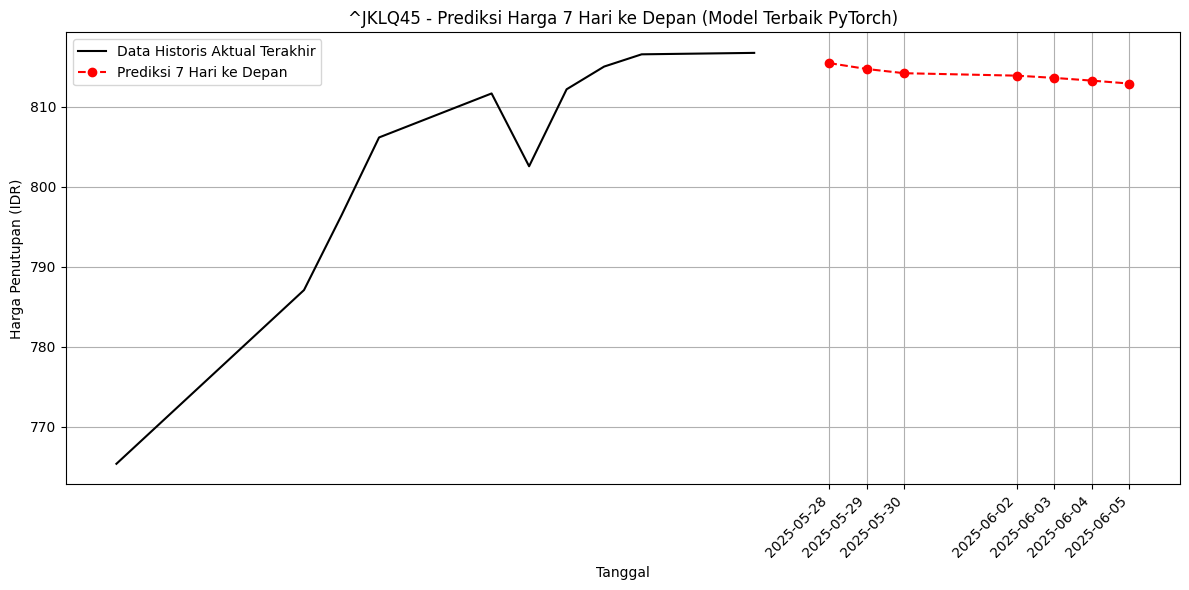

In [ ]:
# 3. Fungsi Prediksi Masa Depan dan Eksekusi

def predict_future_pytorch_load_model(
    model_instance,
    last_sequence_scaled_pt,
    n_steps_future,
    scaler_obj_pt,
    window_size_val_pt,
    n_features_val_pt,
    device_pt
):
    model_instance.eval() # Set ke mode evaluasi
    future_predictions_scaled_pt = []

    # Pindahkan current_sequence_scaled_pt ke device
    current_sequence_scaled_pt = torch.tensor(last_sequence_scaled_pt, dtype=torch.float32).reshape(1, window_size_val_pt, n_features_val_pt).to(device_pt)

    with torch.no_grad():
        for _ in range(n_steps_future):
            next_pred_scaled_pt = model_instance(current_sequence_scaled_pt)
            future_predictions_scaled_pt.append(next_pred_scaled_pt.cpu().item())

            next_pred_for_seq_pt = next_pred_scaled_pt.reshape(1, 1, n_features_val_pt)
            current_sequence_scaled_pt = torch.cat((current_sequence_scaled_pt[:, 1:, :], next_pred_for_seq_pt), dim=1)

    future_predictions_unscaled_pt = scaler_obj_pt.inverse_transform(np.array(future_predictions_scaled_pt).reshape(-1, 1))
    return future_predictions_unscaled_pt

# --- EKSEKUSI PREDIKSI ---
print("\n--- Prediksi 7 Hari ke Depan ---")

# 1. Muat data aktual terakhir untuk membentuk sekuens input awal
print(f"Mengunduh data aktual terakhir hingga {TANGGAL_AKHIR_DATA_AKTUAL}...")
# Kita butuh data yang cukup untuk membentuk WINDOW_SIZE terakhir + data untuk fit scaler
# Idealnya, scaler di-fit pada data training yang sama dengan saat model dilatih.
# Untuk simulasi ini, kita akan fit scaler pada data yang di-download hingga TANGGAL_AKHIR_DATA_AKTUAL,
# dan mengambil BEST_WINDOW_SIZE hari terakhir dari data tersebut.

# Mengambil data yang cukup untuk fit scaler dan sekuens awal.
# Periode awal untuk scaler bisa sama dengan periode training model terbaik,
# atau setidaknya beberapa tahun data.
# Periode akhir adalah TANGGAL_AKHIR_DATA_AKTUAL.
data_for_scaler_fit = yf.download(KODE_INDEKS, start=PERIODE_AWAL_UNTUK_PREDIKSI, end=TANGGAL_AKHIR_DATA_AKTUAL, progress=False) # Periode AWAL dari training
if data_for_scaler_fit.empty:
    raise SystemExit(f"Gagal mengunduh data untuk scaler hingga {TANGGAL_AKHIR_DATA_AKTUAL}")

# Pisahkan data training "sementara" untuk fit scaler
# Ini harusnya mencerminkan data training yang digunakan model terbaikmu.
# Jika periode training model terbaikmu adalah 2005-01-01 s.d. X, gunakan X di sini.
# Sebagai contoh, kita anggap 70% dari data hingga TANGGAL_AKHIR_DATA_AKTUAL adalah data training scaler.
temp_train_size = int(len(data_for_scaler_fit) * TRAIN_RATIO) # Gunakan TRAIN_RATIO yang sama
temp_train_data_for_scaler = data_for_scaler_fit[['Close']].iloc[:temp_train_size]

scaler_for_prediction = MinMaxScaler(feature_range=(0, 1))
scaler_for_prediction.fit(temp_train_data_for_scaler[['Close']]) # Fit pada data training "sementara"

# Ambil BEST_WINDOW_SIZE data aktual terakhir SEBELUM tanggal prediksi
data_aktual_terakhir_df = yf.download(KODE_INDEKS,
                                    start=(pd.to_datetime(TANGGAL_AKHIR_DATA_AKTUAL) - timedelta(days=BEST_WINDOW_SIZE*2)).strftime('%Y-%m-%d'),
                                    end=TANGGAL_AKHIR_DATA_AKTUAL,
                                    progress=False)
if data_aktual_terakhir_df.empty or len(data_aktual_terakhir_df) < BEST_WINDOW_SIZE:
    raise SystemExit(f"Tidak cukup data aktual hingga {TANGGAL_AKHIR_DATA_AKTUAL} untuk window size {BEST_WINDOW_SIZE}")

last_window_data_actual = data_aktual_terakhir_df[['Close']].iloc[-BEST_WINDOW_SIZE:].values
last_window_data_scaled = scaler_for_prediction.transform(last_window_data_actual.reshape(-1, 1))

# 2. Muat model terbaik
best_model_filename_pt = os.path.join(output_dir_pt, f'best_model_pt_w{BEST_WINDOW_SIZE}_b{BEST_BS_PT}_e{BEST_EP_SET_PT}_lr{str(BEST_LR_PT).replace(".", "")}.pth')

if os.path.exists(best_model_filename_pt):
    print(f"Memuat model dari: {best_model_filename_pt}")

    # Buat instance model dengan arsitektur yang sama seperti saat training
    loaded_model = GRUNet(
        input_dim=N_FEATURES,
        hidden_gru_dims_list=BEST_GRU_UNITS_PYTORCH,
        hidden_dense_dim=BEST_DENSE_UNITS_PYTORCH,
        output_dim=1, # Output size pasti 1 untuk regresi harga
        dropout_p=BEST_DROPOUT_RATE_PYTORCH
    )
    loaded_model.load_state_dict(torch.load(best_model_filename_pt, map_location=device))
    loaded_model.to(device)
    loaded_model.eval()

    # 3. Lakukan prediksi
    n_future_days = 7
    tanggal_mulai_prediksi = '2025-05-28'

    future_predictions_unscaled = predict_future_pytorch_load_model(
        loaded_model,
        last_window_data_scaled,
        n_future_days,
        scaler_for_prediction,
        BEST_WINDOW_SIZE,
        N_FEATURES,
        device
    )

    # 4. Tampilkan hasil prediksi (angka)
    print(f"\nPrediksi harga penutupan {KODE_INDEKS} untuk {n_future_days} hari trading ke depan mulai dari {tanggal_mulai_prediksi}:")

    # Generate tanggal prediksi yang benar
    # Tanggal pertama adalah tanggal_mulai_prediksi
    # freq='B' untuk business day (Senin-Jumat, kecuali hari libur yang diketahui Pandas)
    start_pred_date_obj = datetime.strptime(tanggal_mulai_prediksi, '%Y-%m-%d')
    future_pred_dates_actual = pd.date_range(start=start_pred_date_obj, periods=n_future_days, freq='B')

    for i in range(n_future_days):
        print(f"  {future_pred_dates_actual[i].strftime('%Y-%m-%d')}: IDR {future_predictions_unscaled[i,0]:.2f}")

    # 5. Plot hasil prediksi
    plt.figure(figsize=(12, 6))

    # Data aktual terakhir untuk konteks plot
    # Ambil data aktual hingga TANGGAL_AKHIR_DATA_AKTUAL
    data_aktual_plot = data_for_scaler_fit[['Close']].copy() # Menggunakan data yang di-download untuk scaler fit
    data_aktual_plot_terakhir = data_aktual_plot.iloc[-BEST_WINDOW_SIZE*2:] # Ambil beberapa data terakhir

    plt.plot(data_aktual_plot_terakhir.index, data_aktual_plot_terakhir['Close'], label='Data Historis Aktual Terakhir', color='black')
    plt.plot(future_pred_dates_actual, future_predictions_unscaled, label=f'Prediksi {n_future_days} Hari ke Depan', color='red', linestyle='--', marker='o')

    plt.title(f'{KODE_INDEKS} - Prediksi Harga {n_future_days} Hari ke Depan (Model Terbaik PyTorch)')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan (IDR)')
    plt.legend()
    plt.grid(True)
    plt.xticks(future_pred_dates_actual, rotation=45, ha="right") # Set X-ticks hanya untuk tanggal prediksi
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_pt, f'future_prediction_plot_{n_future_days}days_from_{tanggal_mulai_prediksi.replace("-","")}.png'))
    plt.show()

else:
    print(f"File model terbaik {best_model_filename_pt} tidak ditemukan.")
    print("Pastikan parameter model terbaik di Cell 1 sudah benar dan file model ada.")